In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Resizing


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [37]:
# Завантаження VGG16 як згорткової основи
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Заморожування ваг згорткової основи
vgg_base.trainable = False

In [38]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print("x_train shape before processing:", x_train.shape)
print("x_val shape before processing:", x_val.shape)
print("x_test shape before processing:", x_test.shape)

# Додавання каналу до зображень
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Функція для зміни розміру та додавання кольорових каналів
def resize_and_color(img, size=(150, 150)):
    resized_img = tf.image.resize(img, size)
    rgb_img = tf.image.grayscale_to_rgb(resized_img)  # Перетворює зображення в RGB
    return rgb_img.numpy()

# Обробка валідаційних та тестових даних
x_val_rgb = np.array([resize_and_color(img) for img in x_val])
x_test_rgb = np.array([resize_and_color(img) for img in x_test])

print("x_val_rgb shape after processing:", x_val_rgb.shape)
print("x_test_rgb shape after processing:", x_test_rgb.shape)


# # Зміна розміру та перетворення  зображень
# x_train_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_train])
# x_val_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_val])
# x_test_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in x_test])

# # Конвертація зображень з одного каналу в три канали
# #x_train_rgb = np.repeat(x_train_resized[..., np.newaxis], 3, axis=-1)
# x_val_rgb = np.repeat(x_val_resized[..., np.newaxis], 3, axis=-1)
# x_test_rgb = np.repeat(x_test_resized[..., np.newaxis], 3, axis=-1)
# x_val = np.stack([x_val] * 3, axis=-1)
# x_test = np.stack([x_test] * 3, axis=-1)

num_classes = len(np.unique(y_train))

x_train shape before processing: (48000, 28, 28)
x_val shape before processing: (12000, 28, 28)
x_test shape before processing: (10000, 28, 28)
x_val_rgb shape after processing: (12000, 150, 150, 3)
x_test_rgb shape after processing: (10000, 150, 150, 3)


In [39]:
model = Sequential([
    # Змінення розміру вхідних зображень
    #Resizing(150, 150, interpolation='bilinear'),

    # VGG16 як основа
    vgg_base,

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # num_classes = 10 для Fashion-MNIST
])

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# Перегляд структури моделі
model.summary()

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
x_train sh

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    # Зміна розміру зображення
    resized_img = tf.image.resize(img, (150, 150))
    # Додавання кольорових каналів
    rgb_img = tf.repeat(resized_img, 3, axis=-1)
    return rgb_img

print("x_train shape before ImageDataGenerator:", x_train.shape)

# Ініціалізація ImageDataGenerator з аугментацією і нормалізацією
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  # Додавання нормалізації
    preprocessing_function=preprocess_image
)

# Використання datagen.flow для тренувального набору
#train_generator = datagen.flow(x_train, y_train, batch_size=20)


x_train shape before ImageDataGenerator: (48000, 28, 28, 1)


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

class CustomImageGenerator(keras.utils.Sequence):
    def __init__(self, images, labels, batch_size, target_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.images) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Обробка зображень
        processed_batch_x = np.array([self.preprocess_image(img) for img in batch_x])

        return processed_batch_x, np.array(batch_y)

    def preprocess_image(self, image):
        # Збільшення розміру зображення та перетворення до формату RGB
        image = keras.preprocessing.image.smart_resize(image, self.target_size)
        image = np.repeat(image, 3, axis=-1)  # Додавання кольорових каналів
        return image

new_batch = 32

# Створення екземпляра генератора
train_generator = CustomImageGenerator(
    x_train, y_train, 
    batch_size=new_batch, 
    target_size=(150, 150)
)

Batch images shape: (32, 150, 150, 3)
Batch labels shape: (32,)


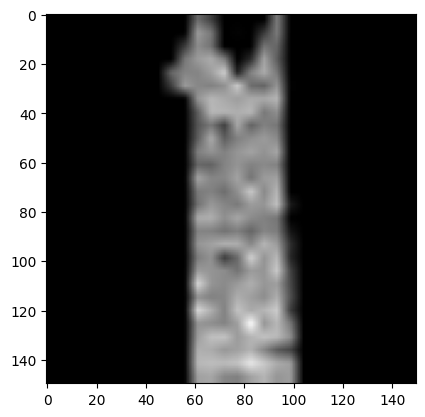

In [32]:
# замість next(), оскільки CustomImageGenerator - це не стандартний ітератор
batch_images, batch_labels = train_generator[0]

# Виведення інформації про форму батчу зображень і міток
print("Batch images shape:", batch_images.shape)  # Очікуємо форму (32, 150, 150, 3)
print("Batch labels shape:", batch_labels.shape)  

# Візуалізація першого зображення з батчу
import matplotlib.pyplot as plt

plt.imshow(batch_images[0].astype('uint8'))  # Чи зображення має правильний тип даних для візуалізації
plt.show()

In [46]:
print("Validation data shape:", x_val_rgb.shape)

# Навчання моделі
history = model.fit(train_generator,
                    steps_per_epoch = len(x_train) // new_batch,
                    epochs = 10,
                    validation_data = (x_val_rgb, y_val)
)

# Донавчання
vgg_base.trainable = True
# Заморожування шарів, крім останніх 4
for layer in vgg_base.layers[:-4]:
    layer.trainable = False


Validation data shape: (12000, 150, 150, 3)
Epoch 1/10
1500/1500 [==============================] - 1877s 1s/step - loss: 0.5381 - accuracy: 0.8173 - val_loss: 0.3437 - val_accuracy: 0.8853
Epoch 2/10
1500/1500 [==============================] - 1879s 1s/step - loss: 0.4983 - accuracy: 0.8333 - val_loss: 0.3389 - val_accuracy: 0.8895
Epoch 3/10
1500/1500 [==============================] - 1896s 1s/step - loss: 0.4631 - accuracy: 0.8427 - val_loss: 0.3116 - val_accuracy: 0.8936
Epoch 4/10
1500/1500 [==============================] - 1893s 1s/step - loss: 0.4419 - accuracy: 0.8489 - val_loss: 0.3177 - val_accuracy: 0.8950
Epoch 5/10
1500/1500 [==============================] - 1879s 1s/step - loss: 0.4282 - accuracy: 0.8544 - val_loss: 0.3265 - val_accuracy: 0.9053
Epoch 6/10
1500/1500 [==============================] - 1873s 1s/step - loss: 0.4215 - accuracy: 0.8590 - val_loss: 0.2969 - val_accuracy: 0.9068
Epoch 7/10
1500/1500 [==============================] - 1873s 1s/step - loss: 0.

In [47]:
# Повторна компіляція моделі
model.compile(optimizer=Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Продовження навчання
history_fine = model.fit(train_generator,
                    steps_per_epoch = len(x_train) // new_batch,
                    epochs = 5,
                    validation_data = (x_val_rgb, y_val)
)

Epoch 1/5
1500/1500 [==============================] - 2183s 1s/step - loss: 0.3185 - accuracy: 0.8915 - val_loss: 0.2996 - val_accuracy: 0.9163
Epoch 2/5
1500/1500 [==============================] - 2178s 1s/step - loss: 0.2749 - accuracy: 0.9026 - val_loss: 0.3005 - val_accuracy: 0.9178
Epoch 3/5
1500/1500 [==============================] - 2169s 1s/step - loss: 0.2393 - accuracy: 0.9126 - val_loss: 0.2958 - val_accuracy: 0.9215
Epoch 4/5
1500/1500 [==============================] - 2176s 1s/step - loss: 0.2236 - accuracy: 0.9175 - val_loss: 0.2885 - val_accuracy: 0.9221
Epoch 5/5
1500/1500 [==============================] - 2167s 1s/step - loss: 0.2012 - accuracy: 0.9255 - val_loss: 0.2887 - val_accuracy: 0.9248


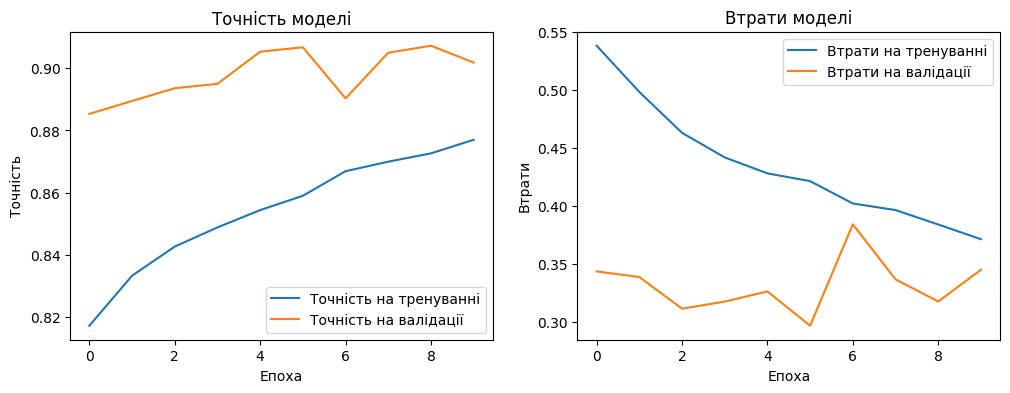

In [48]:
import matplotlib.pyplot as plt

# Графік точності
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.show()

Підсумовуючи результати навчання:   
1. Більша складність моделі ставить набагато більші вимоги до апаратного забезпечення компьютерів на яких відбуваються тренування.
2. У зв'язку з цим необхідно зважувати чи варті такі затрате датасету та бажаній точності до можливих витрат.
3. Дані ускладнені моделі є дуже вимогливими до розмірів датасету для досягнення більшого результату тому це також може ускладнити код для написання підкотовки та тренування моделі у випадк коли системні можливості не у повній мірі задовольняють потреби моделі.
